In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
datapath = "../data/data/v2.0/"
import csv
from collections import defaultdict
import seaborn as sn
# code\data\data\v2.0\hipe2020\en\HIPE-2022-v2.0-hipe2020-dev-en.tsv

In [2]:
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [19]:
test_dataframe = pd.read_csv(datapath+"hipe2020/en/HIPE-2022-v2.0-hipe2020-dev-en.tsv", sep = '\t', header = 0, engine="python", comment='#', quoting=csv.QUOTE_NONE)
# test_dataframe

In [20]:
test_NE = test_dataframe[test_dataframe["NE-COARSE-LIT"] != "O"]
lower_case_dataframe = test_dataframe.copy()
lower_case_dataframe["TOKEN"] = lower_case_dataframe["TOKEN"].str.lower()

In [21]:
data = lower_case_dataframe["TOKEN"].value_counts()
test = data.to_dict()
data

,              1654
the            1620
.              1343
of             1076
and             737
               ... 
.7                1
accustomed        1
conventions       1
thi               1
efficient         1
Name: TOKEN, Length: 6393, dtype: int64

In [22]:
B_prods = test_NE["TOKEN"][test_NE["NE-COARSE-LIT"].isin(["B-prod","I-prod"])]
print(len(B_prods))
token_count = B_prods.value_counts()
print(len(token_count))
token_count

97
72


¬           4
.           4
Guide       4
Journal     3
-           3
           ..
dard        1
SPLENDID    1
Standard    1
Gaz         1
Portland    1
Name: TOKEN, Length: 72, dtype: int64

In [23]:
# plt.bar(test.keys(),test.values())
# plt.show()
test_2 = {key:val for key, val in test.items() if val > 10}
# print(test_2)
# print(len(test))
print(len(test_2))

264


In [ ]:
# plt.figure(figsize=(50,25))
# plt.bar([i*2 for i in range(len(test_2))],test_2.values(), width=0.5)
# plt.xticks([i*2 for i in range(len(test_2))],test_2.keys(), rotation = 90 )
# # plt.show()

In [24]:
test_sum = 0
total = len(test_dataframe)
token_count = 0
token_list = dict()
for key in test:
    token_count += 1
    test_sum += test[key]
    token_list[key] = test[key]
    if test_sum > total * 0.50:
        print(key)
        print(test[key])
        print(token_count)
        print(token_list)
        break

your
34
75
{',': 1654, 'the': 1620, '.': 1343, 'of': 1076, 'and': 737, 'to': 611, 'a': 557, '¬': 539, 'in': 520, 'is': 265, '-': 253, 'that': 214, 'for': 210, 'he': 184, 'be': 173, 'as': 171, 'was': 168, 'it': 167, 'at': 155, 'on': 150, 'by': 148, 'with': 138, 'this': 137, 'will': 127, 'from': 114, 'have': 114, '’': 111, 'his': 107, 'are': 105, 'i': 103, 'their': 102, ';': 100, 'which': 95, 's': 92, 'not': 90, 'they': 85, '*': 81, 'has': 81, '“': 77, "'": 77, 'you': 75, 'an': 74, 'or': 74, 'one': 67, 'all': 66, '”': 65, 'we': 62, 'been': 61, 'but': 59, 'no': 55, 'who': 51, 'our': 47, 'were': 47, 'than': 47, 'other': 46, 'them': 44, 'county': 44, 'any': 44, '—': 44, 'man': 43, 'made': 43, 'when': 43, 'new': 41, 'more': 41, 'j': 39, 'out': 39, 'can': 39, 'there': 39, 'may': 38, 'day': 37, 'would': 37, 'its': 36, ':': 36, 'had': 35, 'your': 34}


In [25]:
NE_COARSE = test_dataframe["NE-COARSE-LIT"]
NE_list = list(pd.unique(NE_COARSE))
NE_list

['O',
 'B-prod',
 'I-prod',
 'B-loc',
 'I-loc',
 'B-org',
 'I-org',
 'B-time',
 'I-time',
 'B-pers',
 'I-pers']

In [26]:
len(test_dataframe.index)

29059

In [38]:
feature_list = list(token_list)
label_list = NE_list

feature_matrix = []
label_matrix = []
# print(np.append(result_matrix,np.zeros(shape=(1,len(token_list))),axis=0))
# result_matrix
pos_dict = defaultdict(lambda: [])
label_dict = defaultdict(lambda: [])
pos = 0
progress = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
prev_label = 0
for idx in test_dataframe.index:
    if idx/len(test_dataframe) > progress[0]:
        print(progress[0])
        progress.pop(0)
    pos += 1
    row = test_dataframe.iloc[idx]
    token = row["TOKEN"]

    if isinstance(token, float):
        continue
    label = row["NE-COARSE-LIT"]

    label_dict[token].append((pos,label,prev_label,0))
    
    prev_label = label_list.index(label)
    
    if token.lower() in feature_list:
        pos_dict[token.lower()].append(pos)

    if isinstance(row["MISC"], float) or "EndOfSentence" not in row["MISC"]:
        continue
    label_dict[token][-1][3] = 1
    for key in label_dict:
        for appearance in label_dict[key]:
            pos = appearance[0]
            label_vector = np.zeros(shape=(len(label_list)+4))
            label_vector[label_list.index(appearance[1])] = 1
            feature_vector = np.zeros(shape=(len(feature_list)))
            
            # add location for each token
            for feature in pos_dict:
                nearest_pos = 100 # I assume there is no feature farther than 100 tokens away from current token in a sentance
                for temp_pos in pos_dict[feature]:
                    relative_pos = temp_pos - pos
                    if abs(relative_pos) < nearest_pos:
                        nearest_pos = relative_pos
                    else:
                        continue
                feature_vector[feature_list.index(feature)] = nearest_pos
            
            # add the current position of the token into the feature vector
            feature_vector[-4] = pos

            #check if first letter of token is uppercase
            if key[0].isupper():
                feature_vector[-3] = 1
            
            feature_vector[-2] = appearance[2]
            feature_vector[-1] = appearance[3]
            feature_matrix.append(feature_vector)
            label_matrix.append(label_vector)           
    pos_dict = defaultdict(lambda: [])
    label_dict = defaultdict(lambda: [])
    pos = 0
    prev_label = 0

feature_matrix = np.array(feature_matrix)
label_matrix = np.array(label_matrix)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [43]:
print(feature_matrix)
print(len(feature_matrix))

[[  0.   1.   4. ...   1.   1.   0.]
 [  0.   0.   3. ...   2.   0.   0.]
 [  0.  -1.   2. ...   3.   1.   0.]
 ...
 [-58. -23. -86. ... 141.   1.   0.]
 [-59. -24. -87. ... 142. -14.   0.]
 [-60. -25. -88. ... 143. -15.   0.]]
29058


In [44]:
print(label_matrix)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [45]:
training_data = feature_matrix[0:int(len(feature_matrix)*0.8)]
test_data = feature_matrix[int(len(feature_matrix)*0.8):]
training_labels = label_matrix[0:int(len(feature_matrix)*0.8)]
test_labels = label_matrix[int(len(feature_matrix)*0.8):]

In [46]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(training_data,training_labels)

DecisionTreeClassifier()

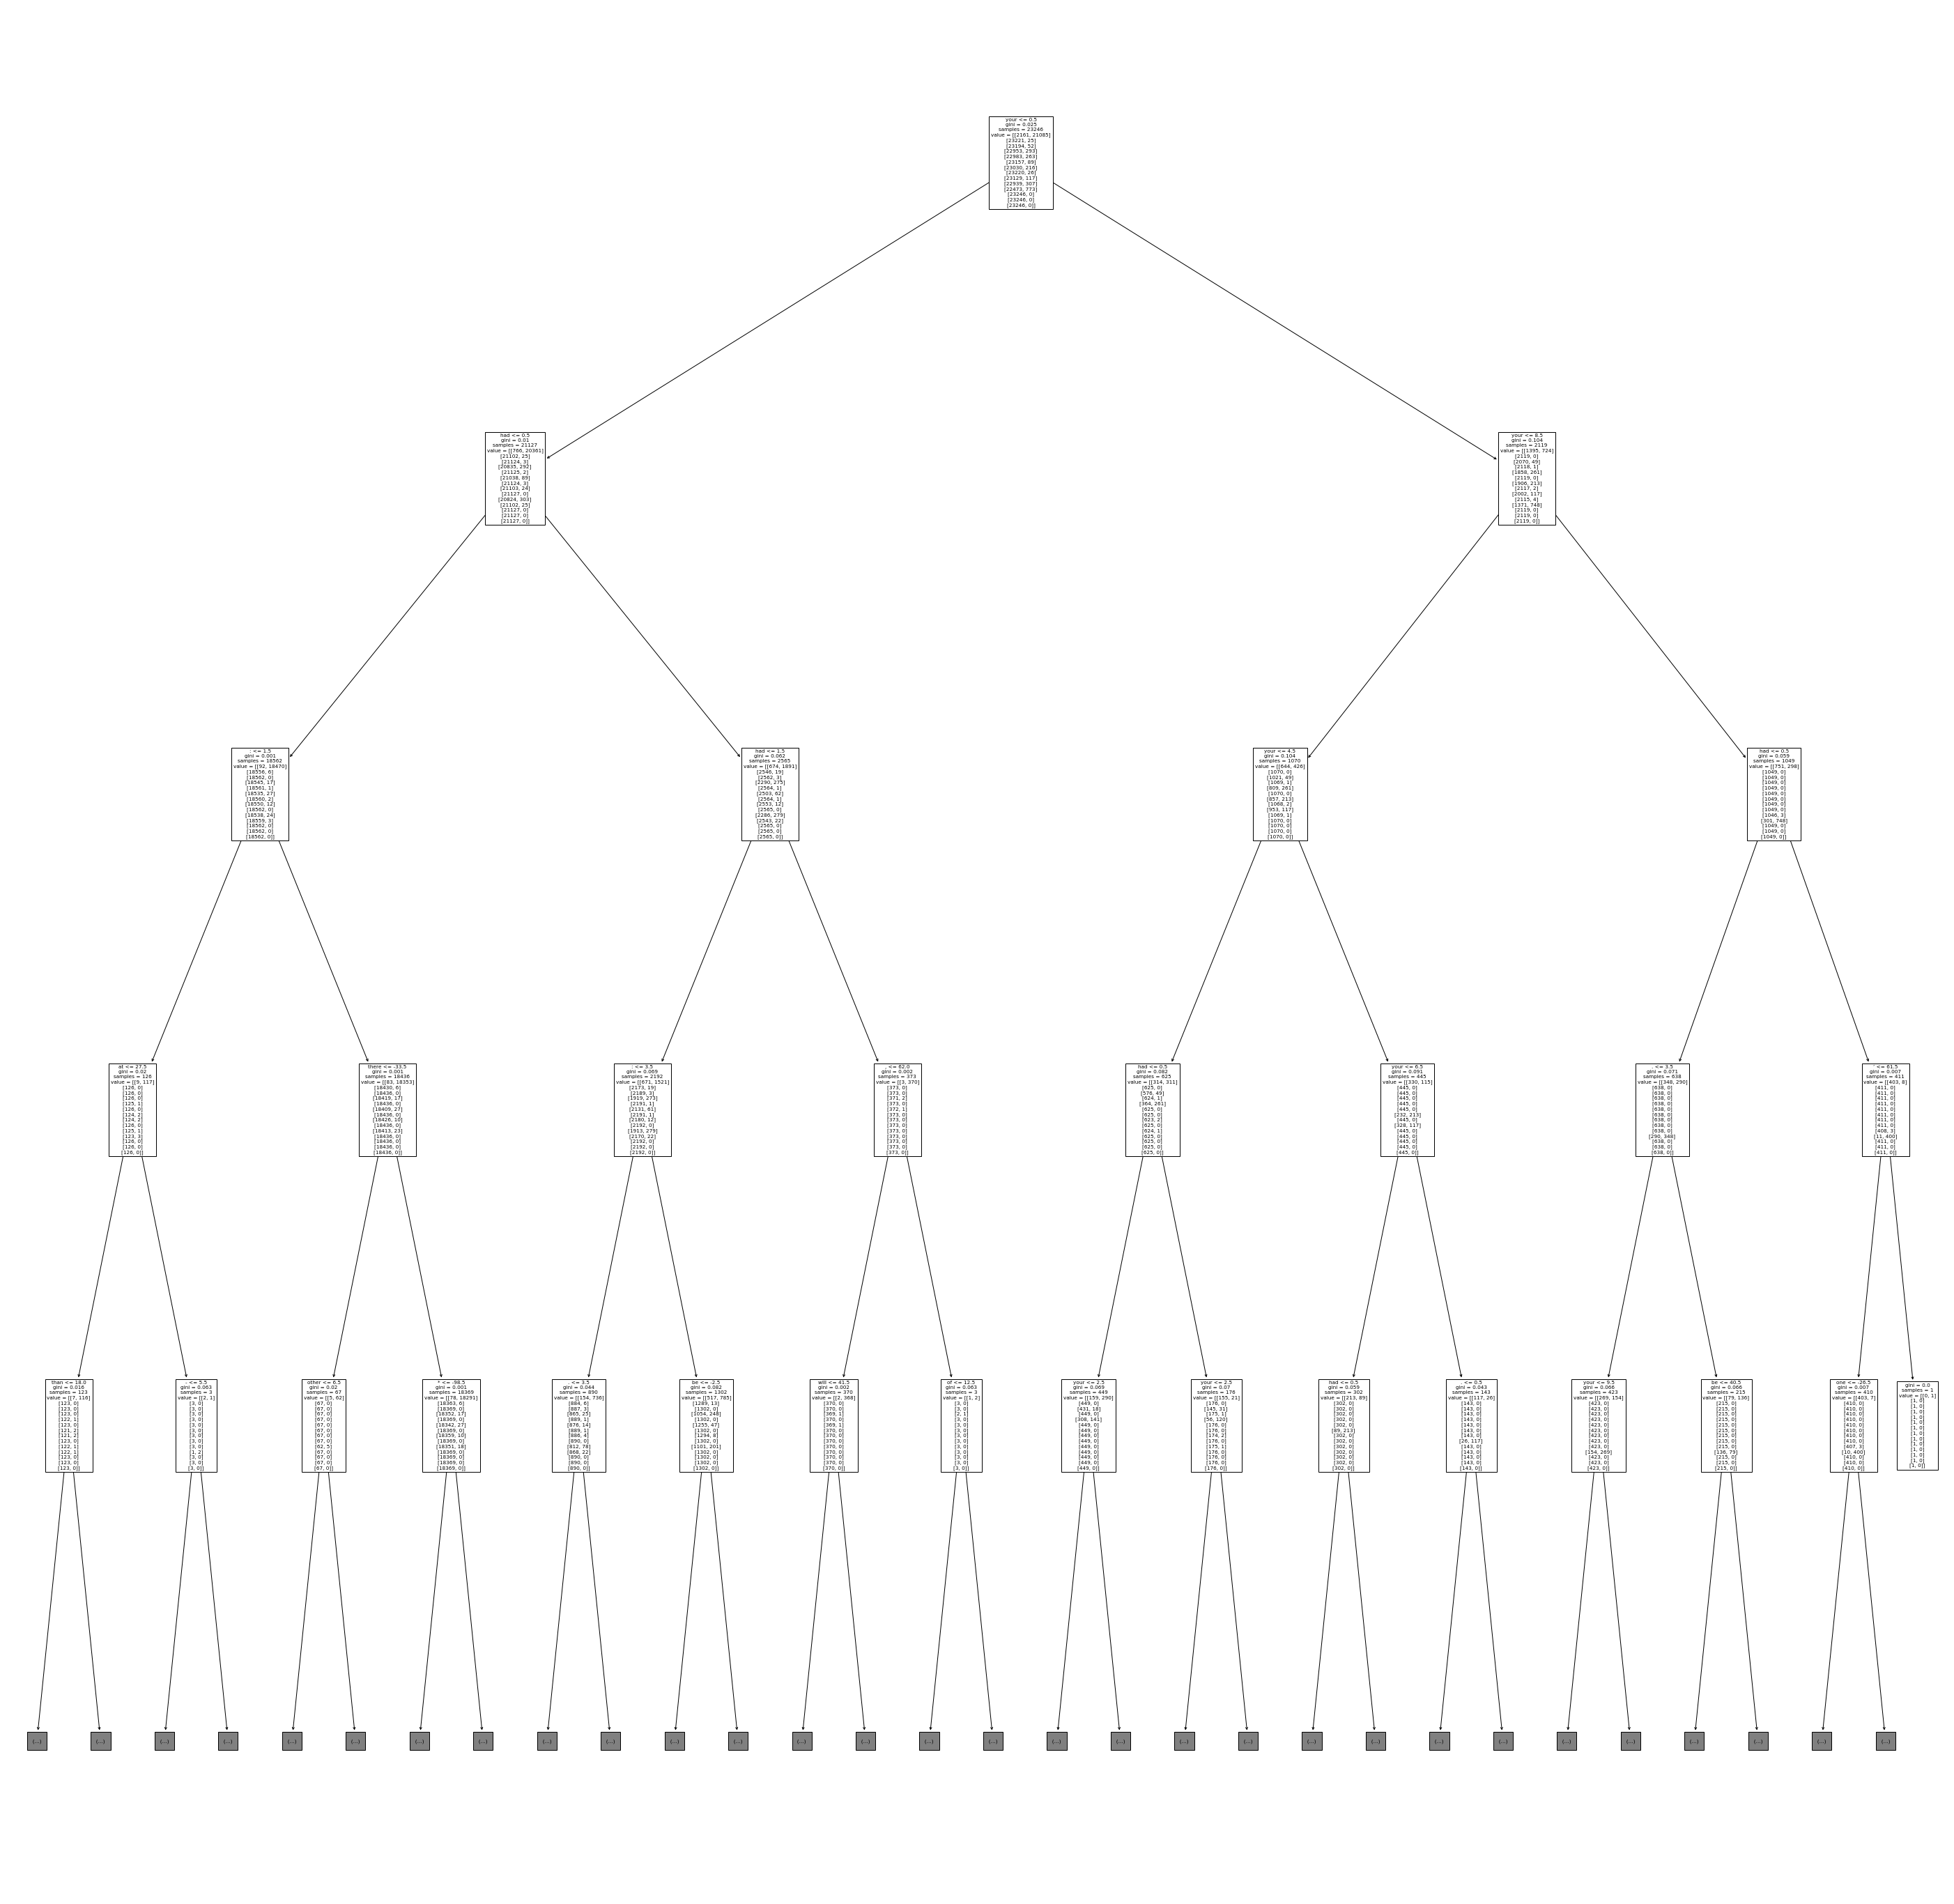

In [47]:
plt.figure(figsize=(50,50))
tree.plot_tree(clf,feature_names = feature_list + ["position", "capitalisation", "prev_label"], class_names= label_list, max_depth=4)
plt.show()

In [51]:
tp = 0
fp = 0
fn = 0
tn = 0
total = 0
prediction = clf.predict(test_data)
prev_label = 0
for i, vector in enumerate(test_data):
    pred = clf.predict([vector])
    print(pred)
    break
    correct_idx = np.where(test_labels[i] == 1)[0][0]
    if correct_idx == 0:
        continue
    total += 1
    if pred[correct_idx] == 1:
        tp += 1
    else:
        fn += 1
print(tp/total)
print(total)
    

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


ZeroDivisionError: division by zero

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
test_labels_flat = []
pred_labels_flat = []
for i in range(len(test_labels)):
    test_idx = list(test_labels[i]).index(1)
    if 1 in list(prediction[i]):
        pred_idx = list(prediction[i]).index(1)
    else:
        pred_idx = 0
    test_labels_flat.append(test_idx)
    pred_labels_flat.append(pred_idx)

In [ ]:
conf_matrix = confusion_matrix(test_labels_flat, pred_labels_flat)